## MEG Group Analysis

Group analysis for MEG data, for the FOOOF paper. 

The Data Source is from the 
[Human Connectome Project](https://www.humanconnectome.org/)

This notebook is for group analysis of MEG data using the 
[omapping](https://github.com/voytekresearch/omapping) module. 

In [1]:
%matplotlib inline

from scipy.io import loadmat
from scipy.stats.stats import pearsonr

from om.meg.single import MegSubj
from om.meg.single import print_corrs_mat, print_corrs_vec
from om.meg.group import MegGroup
from om.meg.group import osc_space_group

from om.plts.meg import *

from om.core.db import OMDB
from om.core.osc import Osc
from om.core.io import load_obj_pickle, save_obj_pickle

## Settings

In [18]:
SAVE_FIG = False

### Setup

In [4]:
# Get database object
db = OMDB()

In [5]:
# Check what data is available
#  Note: this function outa date (checks the wrong file folder)
sub_nums, source = db.check_data_files(dat_type='fooof', dat_source='HCP', verbose=True)

# Drop outlier subject
sub_nums = list(set(sub_nums) - set([662551]))


Number of Subjects available: 81

Subject numbers with FOOOF data available: 
[162026, 153732, 172029, 175540, 825048, 187547, 102816, 512835, 174841, 109123, 164636, 660951, 352132, 250427, 100307, 166438, 221319, 917255, 111514, 158136, 214524, 706040, 283543, 106521, 156334, 559053, 198653, 181232, 212318, 205119, 725751, 581450, 255639, 248339, 195041, 293748, 665254, 191841, 116726, 667056, 352738, 891667, 212823, 140117, 353740, 287248, 898176, 715950, 105923, 185442, 990366, 877168, 154532, 233326, 601127, 599671, 189349, 204521, 679770, 406836, 257845, 112920, 735148, 568963, 116524, 113922, 912447, 162935, 358144, 707749, 223929, 192641, 191437, 814649, 175237, 783462, 555348, 191033, 146129, 662551, 433839]



### Oscillation Band Definitions

In [7]:
# Set up oscillation band definitions to use
bands = Osc()
bands.add_band('Theta', [3, 7])
bands.add_band('Alpha', [7, 14])
bands.add_band('Beta', [15, 30])

### Load Data

In [8]:
# Initialize MegGroup object
meg_group = MegGroup(db, osc)

# Add subjects to meg_group
for i, subj in enumerate(sub_nums):
    meg_subj = MegSubj(OMDB(), source[i], osc)         # Initialize MegSubj object
    meg_subj.import_fooof(subj, get_demo=True)         # Import subject data
    meg_subj.all_oscs(verbose=False)                   # Create vectors of all oscillations
    meg_subj.osc_bands_vertex()                        # Get oscillations per band per vertex
    meg_subj.peak_freq(dat='all', avg='mean')       # Calculate peak frequencies
    meg_group.add_subject(meg_subj,                    # Add subject data to group object
                          add_all_oscs=True,               # Whether to include all-osc data
                          add_vertex_bands=True,           # Whether to include osc-band-vertex data
                          add_peak_freqs=True,             # Whether to include peak frequency data
                          add_vertex_oscs=False,           # Whether to include all-osc data for each vertex
                          add_vertex_exponents=True,       # Whether to include the aperiodic exponent per vertex
                          add_demo=True)                   # Whether to include demographic information

In [9]:
# OR: Check available saved files to load one of them
meg_files = db.check_res_files('meg')


Number of files available: 0

Files available: 




In [10]:
# Load a pickled file
#meg_group = load_obj_pickle('meg', meg_files[2])

### Data Explorations

In [11]:
# Check how many subjects group includes
print('Currently analyzing ' + str(meg_group.n_subjs) + ' subjects.')

Currently analyzing 80 subjects.


In [12]:
# Check data descriptions - sex
print('# of Females:\t', sum(np.array(meg_group.sex) == 'F'))
print('# of Females:\t', sum(np.array(meg_group.sex) == 'M'))

# of Females:	 35
# of Females:	 45


In [13]:
# Check some simple descriptives
print('Number of oscillations found across the whole group: \t', meg_group.n_oscs_tot)
print('Average number of oscillations per vertex: \t\t {:1.2f}'.format(np.mean(meg_group.n_oscs / 7501)))

Number of oscillations found across the whole group: 	 2499704
Average number of oscillations per vertex: 		 4.17


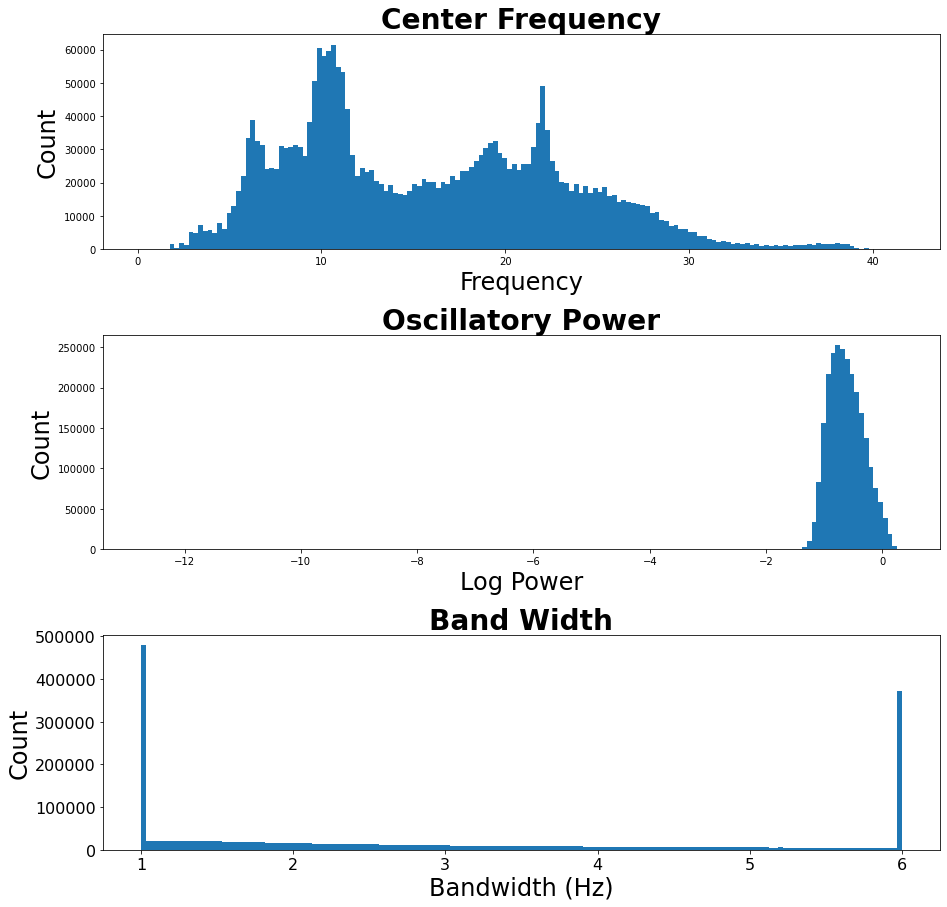

In [16]:
# Plot all oscillations across the group
plot_all_oscs(meg_group.centers_all, meg_group.powers_all, meg_group.bws_all,
              meg_group.comment, save_out=SAVE_FIG)

### Save out probabilities per frequency range

....

In [17]:
# Check for oscillations above / below fitting range
#   Note: this is a quirk of older FOOOF version - fixed in fitting now
print(len(meg_group.centers_all[meg_group.centers_all < 2]))
print(len(meg_group.centers_all[meg_group.centers_all > 40]))

1698
130


In [18]:
# Calculate probability of observing an oscillation in each frequency
bins = np.arange(0, 43, 1)
counts, freqs = np.histogram(meg_group.centers_all, bins=bins)
probs = counts / meg_group.n_oscs_tot

In [19]:
# Fix for the oscillation out of range
add = sum(probs[0:3]) + sum(probs[35:])

freqs = freqs[3:35]
probs = probs[3:35]
probs = probs + (add/len(probs))

In [20]:
# np.save('freqs.npy', freqs)
# np.save('probs.npy', probs)

## BACK TO NORMAL PROGRAMMING

In [20]:
# ??
print(sum(meg_group.powers_all < 0.05) / len(meg_group.powers_all))
print(sum(meg_group.bws_all < 1.0001) / len(meg_group.bws_all))

0.002132252458691109
0.18261122116858636


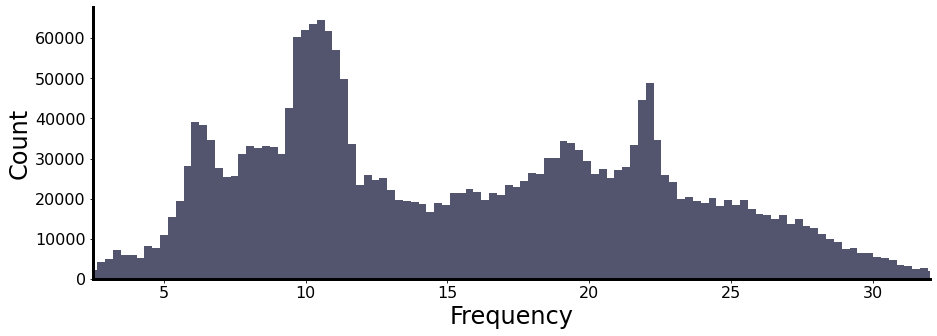

In [23]:
# Plot a single oscillation parameter at a time
plot_all_oscs_single(meg_group.centers_all, 0, meg_group.comment,
                     n_bins=150, figsize=(15, 5))

if True:
    plt.savefig('meg-osc-centers.pdf', bbox_inches='tight')

### Exponents

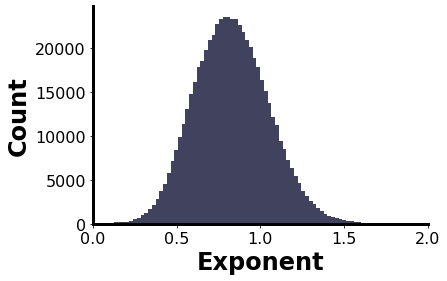

In [27]:
# Plot distribution of all aperiodic exponents
plot_exponents(meg_group.exponents, meg_group.comment, save_out=SAVE_FIG)

In [28]:
# Check the global mean exponent value
print('Global mean exponent value is: \t{:1.4f} with st. dev of {:1.4f}'\
      .format(np.mean(meg_group.exponents), np.std(meg_group.exponents)))

Global mean exponent value is: 	0.8276 with st. dev of 0.2279


In [29]:
# Calculate Average Aperiodic Exponent value per Vertex
meg_group.group_exponent(avg='mean')

In [30]:
# Save out group exponent results
#meg_group.save_gr_exponent(file_name='json')

In [31]:
# Set group exponent results for visualization with Brainstorm
#meg_group.set_exponent_viz()

### Oscillation Topographies

##### Oscillation Probability

In [32]:
# Calculate probability of oscilation (band specific) across the cortex
meg_group.osc_prob()

In [33]:
# Correlations between probabilities of oscillatory bands. 
prob_rs, prob_ps, prob_labels = meg_group.osc_map_corrs(map_type='prob')
print_corrs_mat(prob_rs, prob_ps, prob_labels)

Corr of  Theta-Alpha         is  -0.6736     with p-val of  0.00000
Corr of  Theta-Beta          is  -0.3084     with p-val of  0.00000
Corr of  Alpha-Beta          is  +0.2005     with p-val of  0.00000


In [38]:
# Plot the oscillation probability correlation matrix
#plot_corr_matrix(prob_rs, osc.labels, save_out=SAVE_FIG)

In [39]:
# Save group oscillation probability data for visualization with Brainstorm
meg_group.set_map_viz(map_type='prob', file_name='json')

In [40]:
# Save group oscillation probability data out to npz file
#meg_group.save_map(map_type='prob', file_name='json')

##### Oscillation Power Ratio

In [41]:
# Calculate power ratio of oscilation (band specific) across the cortex
meg_group.osc_power()

In [42]:
# Correlations between probabilities of oscillatory bands. 
power_rs, power_ps, power_labels = meg_group.osc_map_corrs(map_type='power')
print_corrs_mat(power_rs, power_ps, power_labels)

Corr of  Theta-Alpha         is  -0.5050     with p-val of  0.00000
Corr of  Theta-Beta          is  -0.4081     with p-val of  0.00000
Corr of  Alpha-Beta          is  +0.7794     with p-val of  0.00000


In [53]:
# Plot the oscillation probability correlation matrix
#plot_corr_matrix(power_rs, osc.labels, save_out=SAVE_FIG)

In [54]:
# Save group oscillation probability data for visualization with Brainstorm
meg_group.set_map_viz(map_type='power', file_name='json')

In [55]:
# Save group oscillation probability data out to npz file
#meg_group.save_map(map_type='power', file_name='json')

##### Oscillation Score

In [50]:
# Calculate oscillation score
meg_group.osc_score()

In [51]:
# Save group oscillation probability data for visualization with Brainstorm
#meg_group.set_map_viz(map_type='score', file_name='json')

In [52]:
# Save group oscillation score data out to npz file
#meg_group.save_map(map_type='score', file_name='80_new_group')

In [53]:
# Correlations between osc-scores of oscillatory bands.
score_rs, score_ps, score_labels = meg_group.osc_map_corrs(map_type='score')
print_corrs_mat(score_rs, score_ps, score_labels)

Corr of  Theta-Alpha         is  -0.5971     with p-val of  0.00000
Corr of  Theta-Beta          is  -0.4088     with p-val of  0.00000
Corr of  Alpha-Beta          is  +0.7214     with p-val of  0.00000


In [54]:
# Plot the oscillation score correlation matrix
#plot_corr_matrix(score_rs, osc.labels, save_out=SAVE_FIG)

In [55]:
# Save out pickle file of current MegGroup() object
#save_obj_pickle(meg_group, 'meg', 'test')

#### Check correlation of aperiodic exponent with oscillation bands

In [56]:
n_bands = len(meg_group.bands)
exp_rs = np.zeros(shape=[n_bands])
exp_ps = np.zeros(shape=[n_bands])
for ind, band in enumerate(meg_group.bands):
    r_val, p_val = pearsonr(meg_group.exponent_gr_avg, meg_group.osc_scores[band])
    exp_rs[ind] = r_val
    exp_ps[ind] = p_val

In [57]:
for rv, pv, label in zip(exp_rs, exp_ps, ['Theta', 'Alpha', 'Beta']):
    print('Corr of {}-Exp \t is {:1.2f} \t with p-val of {:1.2f}'.format(label, rv, pv))

Corr of Theta-Exp 	 is -0.30 	 with p-val of 0.00
Corr of Alpha-Exp 	 is 0.83 	 with p-val of 0.00
Corr of Beta-Exp 	 is 0.54 	 with p-val of 0.00


#### Plot corr matrix including bands & exponents

In [58]:
all_rs = np.zeros(shape=[n_bands+1, n_bands+1])
all_rs[0:n_bands, 0:n_bands] = score_rs

all_rs[n_bands, 0:n_bands] = exp_rs
all_rs[0:n_bands, n_bands] = exp_rs;

from copy import deepcopy
all_labels = deepcopy(osc.labels)
all_labels.append('Exps')

In [59]:
#plot_corr_matrix_tri(all_rs, all_labels)
#if SAVE_FIG:
#    plt.savefig('Corrs.pdf')

In [60]:
corr_data = all_rs
labels = all_labels

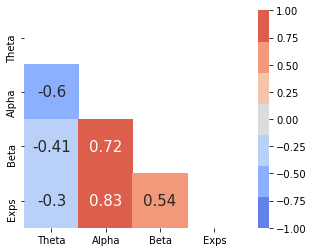

In [61]:
# TEMP / HACK - MAKE & SAVE CORR-PLOT
# Generate a mask for the upper triangle
mask = np.zeros_like(corr_data, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.color_palette("coolwarm", 7)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_data, mask=mask, cmap=cmap, annot=True, square=True, annot_kws={"size":15},
            vmin=-1, vmax=1, xticklabels=labels, yticklabels=labels)
plt.savefig('corr.pdf')

In [63]:
#plot_corr_matrix(all_rs, all_labels, save_out=SAVE_FIG)